In [3]:
# Import correct path
import os,sys
g_selfatt_source =  os.path.join(os.getcwd(), '..')
if g_selfatt_source not in sys.path:
    sys.path.append(g_selfatt_source)
    
g_selfatt_source_2 = os.path.join(g_selfatt_source, 'src')
if g_selfatt_source_2 not in sys.path:
    sys.path.append(g_selfatt_source_2)

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
from datasets import MNIST_rot
import torchvision.transforms.functional as TF
from PIL import Image, ImageOps
import models
import g_selfatt.groups as groups

In [7]:
# First create a dataloader with batchsize one
data_mean = (0.1307,)
data_stddev = (0.3081,)
transform_test = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(data_mean, data_stddev),
    ]
)
test_set = MNIST_rot(root="../data", stage="train", download=True, transform=transform_test, data_fraction=1, only_3_and_8=True)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=1,
    shuffle=False,
    num_workers=4,
)

Now get one data image and push it through the model

In [8]:
# Get datapoint
data = iter(test_loader)
for _ in range(19): #Cherry picked the 12th image
    image, idx = next(data)

/Users/jasper/opt/anaconda3/envs/MAIN_environment/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/jasper/opt/anaconda3/envs/MAIN_environment/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowIxEET_S2_S2_b
  Referenced from: <870081F6-12FD-3CEA-BC5C-30F4764F2A98> /Users/jasper/opt/anaconda3/envs/MAIN_environment/lib/python3.8/site-packages/torchvision/image.so
  Expected in:     <F2FE5CF8-5B5B-3FAD-ADF8-C77D90F49FC9> /Users/jasper/opt/anaconda3/envs/MAIN_environment/lib/python3.8/site-packages/torch/lib/libc10.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/jasper/opt/anaconda3/envs/MAIN_environment/lib/python3.8/site-packages/tor

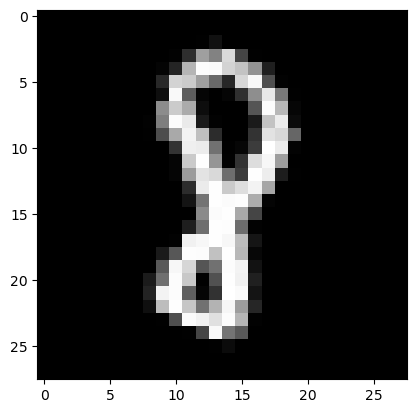

In [9]:
image = image.squeeze()  # Batch dimension
plt.imshow(image.cpu().numpy(), cmap="gray")
plt.show()

In [16]:
# Now import GE-ViT of the models and run it on the image
model = models.GroupTransformer(
    group=groups.E2(num_elements=8),
    in_channels=1,
    num_channels=20,
    block_sizes=[2, 3],
    expansion_per_block=1,
    crop_per_layer=[2, 0, 2, 1, 1],
    image_size=28,
    num_classes=2,
    dropout_rate_after_maxpooling=0.0,
    maxpool_after_last_block=False,
    normalize_between_layers=False,
    patch_size=5,
    num_heads=9,
    norm_type="LayerNorm",
    activation_function="Swish",
    attention_dropout_rate=0.1,
    value_dropout_rate=0.1,
    whitening_scale=1.41421356,
)
print(f"The working directory is {os.getcwd()}")
model_path = "../src/saved/results/rotMNIST_model_p4msa_type_Local_patch_5_dpatt_0.1_dpval_0.1_activ_Swish_norm_LayerNorm_white_1.41421356_optim_Adam_lr_0.001_bs_16_ep_50_wd_0.0001_seed_0_sched_constants_schdec_1.0.pt"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = torch.nn.DataParallel(model)
model.load_state_dict(torch.load(model_path, map_location=device), strict=False)

The working directory is /Users/jasper/Library/CloudStorage/GoogleDrive-jasper.eppink@gmail.com/My Drive/Documents/school/Master/AI/Jaar 1/Deep Learning 2/Project/Project git MAIN/GEVit-DL2-Project/demos


<All keys matched successfully>

In [7]:
def rotate_image(image, degree, show=False):
    """ Returns all transformations of the input images """
    # First change image from tensor to PIL
    image = image.squeeze()
    image = image.cpu().numpy()
    image = Image.fromarray(image)
    
    transform = TF.rotate(image, degree)

    # Now convert back to tensor
    transform = TF.to_tensor(transform)
    transform = transform.squeeze()
    if show:
        plt.imshow(transform.cpu().numpy(), cmap="gray")
        plt.show()


    return transform  # C, H, W

## Now create the visualisation of the digit with the slider

In [8]:
#%matplotlib widget
#!conda install jupyter-matplotlib

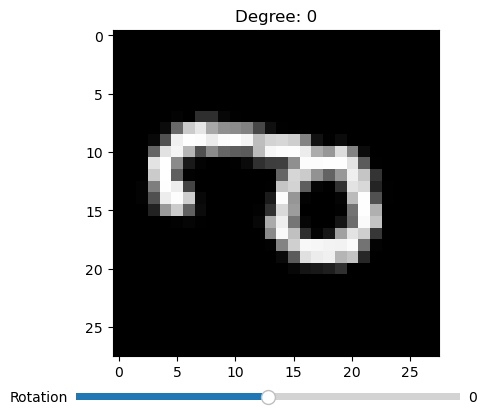

In [9]:
from matplotlib.widgets import Button, Slider

# The image I want to show rotated is image, now I want to create a slider that rotates the image
fig, ax = plt.subplots()
plt.subplots_adjust(bottom=0.2)
degree = 0
rotated_image = rotate_image(image, degree)
image_plot = ax.imshow(rotated_image.cpu().numpy(), cmap="gray")
ax.set_title("Degree: {}".format(degree))

# Define the slider update function
def update_rotation(val):
    degree = val
    rotated_image = rotate_image(image, degree)
    image_plot.set_data(rotated_image.cpu().numpy())
    ax.set_title("Degree: {}".format(degree))
    fig.canvas.draw_idle()

# Create the slider
slider_ax = plt.axes([0.2, 0.1, 0.6, 0.03])
slider = Slider(slider_ax, 'Rotation', -180, 180, valinit=degree)
slider.on_changed(update_rotation)

plt.show()